In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

conn = mysql.connector.connect(host = "localhost",
                               username = 'root',
                               password = 'root',
                               database = "ecommerce")

cur = conn.cursor()

# List all unique cities where customers are located.

In [33]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ['Cities'])
df.head()

,Cities
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [11]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
data[0][0]

90202

# Find the total sales per category.

In [20]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2) sales 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category 
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=['Category','Sales'])
df

,Category,Sales
0,PERFUMERY,2026954.64
1,FURNITURE DECORATION,5720705.57
2,TELEPHONY,1947528.20
3,BED TABLE BATH,6850214.68
4,AUTOMOTIVE,3409177.32
...,...,...
69,CDS MUSIC DVDS,4797.72
70,LA CUISINE,11654.12
71,FASHION CHILDREN'S CLOTHING,3142.68
72,PC GAMER,8697.72


# Calculate the percentage of orders that were paid in installments.

In [23]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end ))/count(*)*100 from payments """

cur.execute(query)
data = cur.fetchall()
print(f"percentage of orders that were paid in installments:",data[0][0])

percentage of orders that were paid in installments: 99.9981


# Count the number of customers from each state.

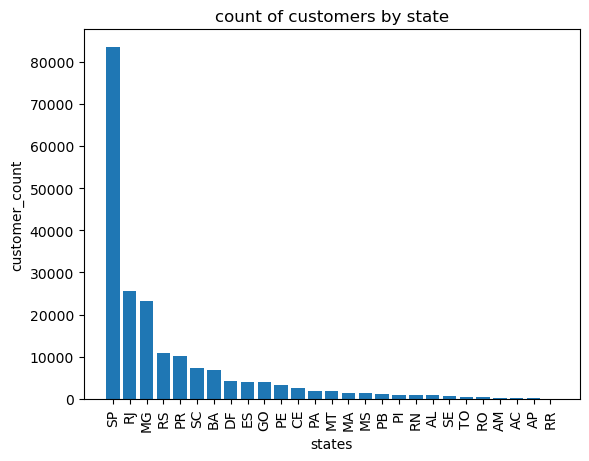

In [14]:
query = """ select customer_state , count(customer_id) from customers group by customer_state """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ["State","Total_Customer"])
df = df.sort_values(by = "Total_Customer", ascending= False)
plt.bar(df['State'],df['Total_Customer'])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("count of customers by state")
plt.show()

# Calculate the number of orders per month in 2018.

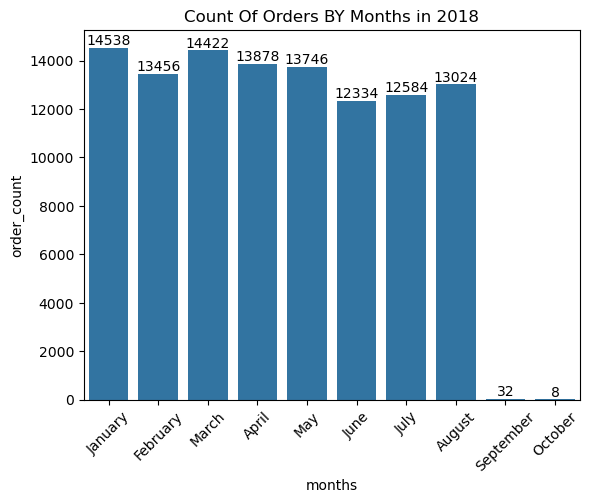

In [15]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018 group by months"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April","May", "June", "July", "August","September", "October"]
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df ,order = o)
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 45)
plt.title("Count Of Orders BY Months in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [23]:
query = """
with count_per_order as (
select orders.order_id , orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["customer_city","average products per order"])
df.head(10)

,customer_city,average products per order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,picarra,8.00
7,morro de sao paulo,8.00
8,teixeira soares,8.00
9,curralinho,8.00


# Calculate the percentage of total revenue contributed by each product category.

In [5]:
query = """select upper(products.product_category) category,  round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["category","sales_percentage"])
df.head(10)

,category,sales_percentage
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
5,SPORT LEISURE,17.39
6,HOUSEWARES,13.68
7,AUTOMOTIVE,10.65
8,GARDEN TOOLS,10.47
9,COOL STUFF,9.74


# Identify the correlation between product price and the number of times a product has been purchased.

In [9]:
query = """ select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["category","order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef(arr1,arr2)

print("the correaltion is ", a[0][1])

the correaltion is  -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [9]:
query = """select * , dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["seller_id","revenue","rank"])
df.head()

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,1.014334e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,6.164441e+05,2
2,4a3ca9315b744ce9f8e9374361493884,6.024905e+05,3
3,1f50f920176fa81dab994f9023523100,5.805068e+05,4
4,53243585a1d6dc2643021fd1853d8905,5.698062e+05,5


# Calculate the cumulative sales per month for each year.

In [6]:
query = """select years, months, payment, sum(payment) 
over(order by years, months) cummulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years","months","payment","cummulative_sales"])
df

,years,months,payment,cummulative_sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


# Calculate the year-over-year growth rate of total sales

In [13]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as sales from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, (sales - lag(sales,1) over(order by years))/ lag(sales,1) over(order by years) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year.

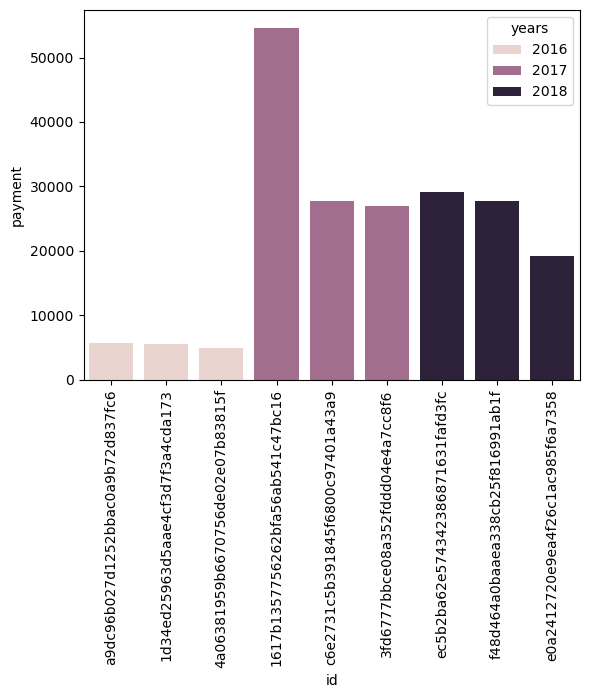

In [14]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()
